# Main Visualization

This notebook produces the main visualization (Figure 3) of validation results, and computes p-values for results compared to the permutation tests. In order to run this, specify the folder name of the run you want to test, e.g. `1747831228_rf_outer3_cvrep5_k3_auc_testsize0.3_permFalse` as `folder`.

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import scipy.stats as stats
import os

from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text

In [16]:
class HandlerText(HandlerBase):
    def create_artists(self, legend, orig_handle, x0, y0, width, height, fontsize, trans):
        t = Text(x=x0, y=y0, text=orig_handle.get_text(), color='red', fontsize=fontsize)
        return [t]

In [17]:
folder = '1750853719_321_rf_outer100_cvrep5_k3_auc_testsize0.3_permFalse'
RES_DIR = os.path.join('../results', folder)

In [18]:
def plot_model_performance(res_dir):
    """
    Plots model performance comparing permutation vs non-permutation runs.
    
    Args:
        res_dir (str): Results directory for the run to visualize
    """

    perm_folder = os.path.join(res_dir, 'permutation_test', )

    perm_folder = os.path.join(res_dir, 'permutation_test')
    subfolders = [f for f in os.listdir(perm_folder) if os.path.isdir(os.path.join(perm_folder, f))]
    assert len(subfolders) == 1, "Expected exactly one subfolder"
    perm_folder = os.path.join(perm_folder, subfolders[0])


    test_scores_path = os.path.join(res_dir, "test_scores.csv")
    all_test_scores_nonperm_path = os.path.join(res_dir, "all_test_scores.csv")
    all_test_scores_perm_path = os.path.join(perm_folder, "all_test_scores.csv")

    # Existing plotting logic goes here, using the three files above

    df = pd.read_csv(test_scores_path)
    perm_df = pd.read_csv(all_test_scores_perm_path)
    all_test_df = pd.read_csv(all_test_scores_nonperm_path)

    perm_df["group"] = perm_df["group"].apply(ast.literal_eval)
    all_test_df["group"] = all_test_df["group"].apply(ast.literal_eval)

    factor_map = {
        "group_sub": "GRP", "alc_self": "ALC", "psych": "PSY",
        "group_socio": "SOC", "brain": "NI", "demo": "D"
    }

    df["Factor_Label"] = df.apply(
        lambda row: "-".join(sorted([factor_map.get(f, f) for f in [row["Factor_1"], row["Factor_2"]] if pd.notna(f)])),
        axis=1
    )

    factor_order = [
        "SOC-NI", "GRP-NI", "GRP-SOC", "PSY-NI", "PSY-SOC", "PSY-GRP", 
        "ALC-NI", "ALC-SOC", "ALC-GRP", "ALC-PSY", "D-NI", "D-SOC", 
        "D-GRP", "D-PSY", "D-ALC", "NI", "SOC", "GRP", "PSY", "ALC", "D"
    ]
    factor_order.reverse()

    df_filtered = df[df["Factor_Label"].isin(factor_order)].copy()
    df_filtered["Factor_Label"] = pd.Categorical(df_filtered["Factor_Label"], categories=factor_order, ordered=True)
    df_filtered = df_filtered.sort_values(by="Factor_Label", ascending=False)

    metrics = ["auc", "f1", "balancedAcc"]
    thresholds = {"auc": 0.7, "f1": 0.37, "balancedAcc": 0.5}

    results_list = []

    for _, row in df_filtered.iterrows():
        factor_tuple = tuple(sorted(filter(pd.notna, [row["Factor_1"], row["Factor_2"]])))
        perm_values = perm_df[perm_df["group"].apply(lambda x: tuple(sorted(x))) == factor_tuple]
        all_test_values = all_test_df[all_test_df["group"].apply(lambda x: tuple(sorted(x))) == factor_tuple]

        for metric in metrics:
            perm_metric_values = perm_values[metric]
            all_metric_values = all_test_values[metric]

            perm_p_value = (perm_metric_values >= row[f"{metric}_mean"]).sum() / len(perm_metric_values)
            t_stat, ttest_p_value = stats.ttest_ind(all_metric_values, perm_metric_values, equal_var=False)

            results_list.append({
                "Factor": row["Factor_Label"],
                "Metric": metric,
                "Permutation_p": perm_p_value,
                "TTest_p": ttest_p_value
            })

    results_df = pd.DataFrame(results_list)
    # print(results_df)

    fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True)
    plot_settings = [("AUC (95% CI)", "auc"), ("F1 Score (95% CI)", "f1"), ("Balanced Accuracy (95% CI)", "balancedAcc")]
    fig.suptitle("Model evaluation metrics for nested CV (k=3, j=5, i=100)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 1])
    # fig.supxlabel("Features Categories", x=0.01, y=0.5, fontsize=16, rotation=90)

    for ax, (title, metric) in zip(axes, plot_settings):
        ax.axvline(thresholds[metric], color="#4D194D", linestyle="--")

        for i, factor in enumerate(df_filtered["Factor_Label"]):
            mean = df_filtered[f"{metric}_mean"].iloc[i]
            lower = df_filtered[f"{metric}_CI_lower"].iloc[i]
            upper = df_filtered[f"{metric}_CI_upper"].iloc[i]
            transparency = 0.5 if lower < thresholds[metric] else 1.0

            ax.scatter(mean, factor, color="#065A60", alpha=transparency)
            ax.plot([lower, upper], [factor, factor], color="#065A60", alpha=transparency)

            perm_p = results_df[(results_df.Factor == factor) & (results_df.Metric == metric)].Permutation_p.values[0]
            if perm_p < 0.05:
                ax.text(mean + 0.005, factor, "*", color="red", fontsize=14, alpha=transparency)
            if perm_p < 0.01:
                ax.text(mean + 0.005, factor, "**", color="red", fontsize=14, alpha=transparency)

        ax.set_xlabel(title, fontsize=16)
        ax.tick_params(axis='both', labelsize=14)
        ax.grid(True)

    star1 = Text(0, 0, '*')
    star2 = Text(0, 0, '**')

    axes[2].legend([star1, star2],
                ['Permutation Test p < 0.05', 'Permutation Test p < 0.01'],
                handler_map={star1: HandlerText(), star2: HandlerText()},
                loc='upper right', fontsize=12)
    # axes[2].legend(handles=[legend_element, legend_element_2], loc='upper right', fontsize=12)

    # Prepare GRP data for swarm+box plot
    grp_tuple = ("group_sub",)
    perm_grp = perm_df[perm_df["group"].apply(lambda x: tuple(sorted(x))) == grp_tuple].copy()
    all_grp = all_test_df[all_test_df["group"].apply(lambda x: tuple(sorted(x))) == grp_tuple].copy()

    perm_grp["type"] = "Permuted"
    all_grp["type"] = "Real"

    combined = pd.concat([perm_grp, all_grp], ignore_index=True)

    # Melt dataframe for seaborn
    melted = combined.melt(id_vars=["type"], value_vars=metrics, var_name="Metric", value_name="Score")

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=melted, x="Metric", y="Score", hue="type", fliersize=0, width=0.6, palette=["#C08497", "#88D9E6"], boxprops=dict(facecolor='none'))
    sns.swarmplot(data=melted, x="Metric", y="Score", hue="type", dodge=True, palette=["#C08497", "#88D9E6"], alpha=0.7, size=4)

    plt.title("Real vs. Permuted Test Metric Distributions for GRP", fontsize=16)
    plt.xlabel("Metric", fontsize=14)
    plt.ylabel("Score", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title="Data Type", fontsize=12, title_fontsize=13)

    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()


    return results_df


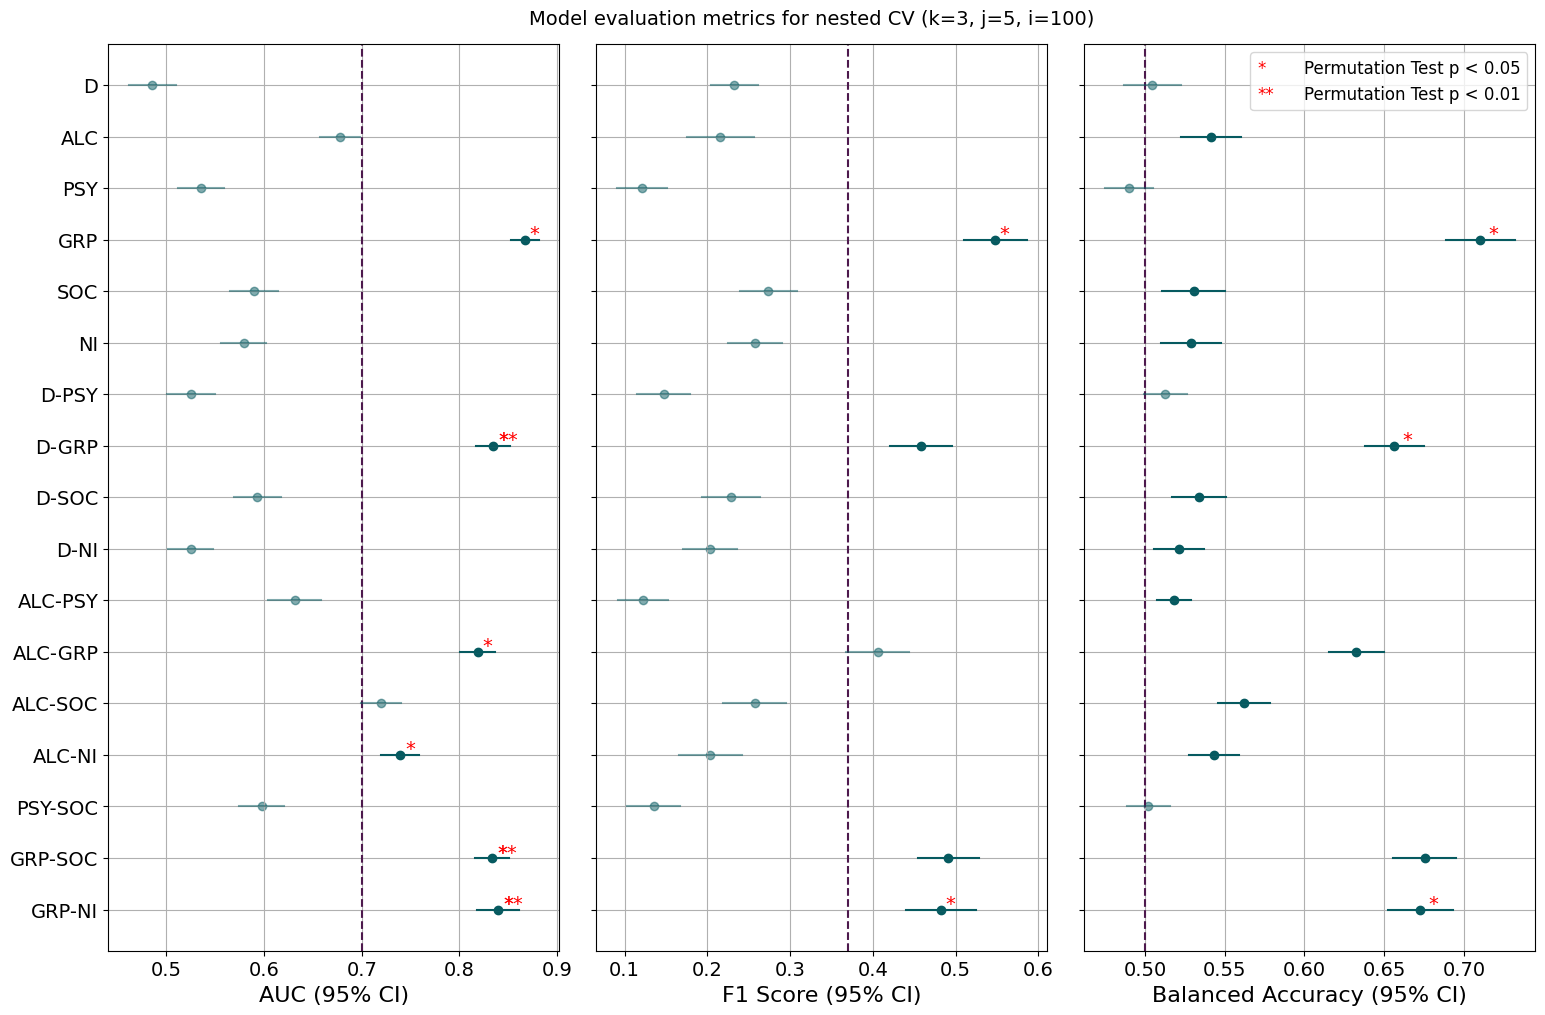

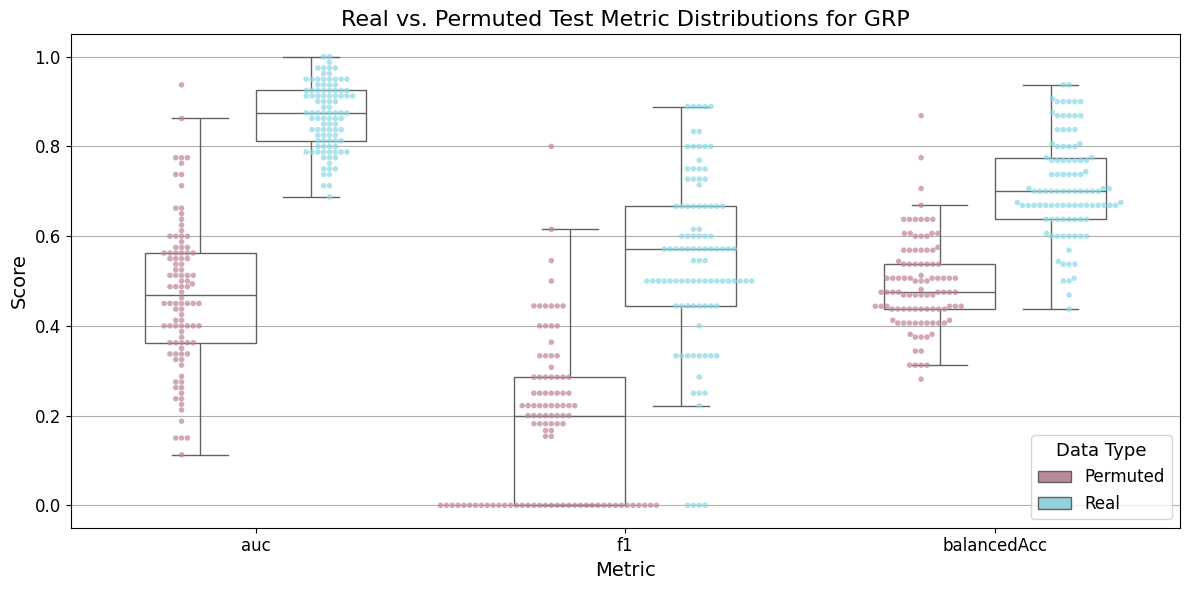

,Factor,Metric,Permutation_p,TTest_p
0,GRP-NI,auc,0.00,2.830276e-42
1,GRP-NI,f1,0.02,3.295186e-26
2,GRP-NI,balancedAcc,0.01,1.892470e-28
3,GRP-SOC,auc,0.00,8.093811e-42
4,GRP-SOC,f1,0.06,7.202803e-26
5,GRP-SOC,balancedAcc,0.05,2.877974e-26
6,PSY-SOC,auc,0.26,1.611616e-07
7,PSY-SOC,f1,0.32,6.922676e-02
8,PSY-SOC,balancedAcc,0.30,4.801181e-01
9,ALC-NI,auc,0.02,1.569779e-31


In [21]:
plot_model_performance(
    res_dir=RES_DIR
)

Save formatted final results table.

In [ ]:
# Load original CSV
df = pd.read_csv(os.path.join(RES_DIR, "test_scores.csv")) 

# Metrics to include and format
selected_metrics = ["auc", "f1", "balancedAcc", "sensitivity", "specificity", "pr_auc"]

# Build formatted output
output_rows = []

for _, row in df.iterrows():
    row_dict = {}

    # Combine Factor_1 and Factor_2 into "Feature Category"
    factor_1 = row['Factor_1']
    factor_2 = row['Factor_2']
    if pd.isna(factor_2) or str(factor_2).strip() == "":
        row_dict["Feature Category"] = str(factor_1)
    else:
        row_dict["Feature Category"] = f"{factor_1}-{factor_2}"

    # Format selected metrics with newline and 3 decimal precision
    for metric in selected_metrics:
        mean = f"{row[f'{metric}_mean']:.3f}"
        ci_low = f"{row[f'{metric}_CI_lower']:.3f}"
        ci_up = f"{row[f'{metric}_CI_upper']:.3f}"
        row_dict[metric.upper()] = f"{mean}\n({ci_low}–{ci_up})"

    output_rows.append(row_dict)

# Create and save the final DataFrame
df_out = pd.DataFrame(output_rows)

# Save to new CSV
df_out.to_csv(os.path.join(RES_DIR, "formatted_metrics_table.csv"), index=False)
